In [6]:
import unittest
from SimPEG import EM, Mesh, Utils, np, Maps, sp
# import sys
from scipy.constants import mu_0
%pylab inline
import matplotlib.pyplot as plt

tol_EBdipole = 1e-2


# Define model parameters
sigmaback = 1.
kappa = 0.

# Set source parameters
freq = 1.
src_loc = np.r_[0., 0., 0.]

# Compute skin depth
skdpth = 500. / np.sqrt(sigmaback * freq)

# Create cylindrical mesh
csx, ncx, npadx = 5, 50, 25
csz, ncz, npadz = 5, 50, 25
hx = Utils.meshTensor([(csx, ncx), (csx, npadx, 1.3)])
hz = Utils.meshTensor([(csz, npadz, -1.3), (csz, ncz), (csz, npadz, 1.3)])
mesh = Mesh.CylMesh([hx, 1, hz], [0., 0., -hz.sum()/2])


# make sure mesh is big enough
checkZ = mesh.hz.sum() > skdpth*2.
checkX = mesh.hx.sum() > skdpth*2.
print checkX,checkZ
# self.assertTrue(mesh.hz.sum() > skdpth*2.)
# self.assertTrue(mesh.hx.sum() > skdpth*2.)

# Create wholespace models
SigmaBack = sigmaback*np.ones((mesh.nC))
MuBack = (mu_0*(1 + kappa))*np.ones((mesh.nC))

print('Testing various componemts of the analytic harmonic electric dipole against a numerical solution on a cylindrical mesh')

# Define the source
# Search over z-faces to find face nearest src_loc then add nFx to get to global face index [nFx][nFy = 0][nFz]
s_ind = Utils.closestPoints(mesh, src_loc, 'Fz') + mesh.nFx
de = np.zeros(mesh.nF, dtype=complex)
de[s_ind] = 1./csz
de_p = [EM.FDEM.Src.RawVec_e([], freq, de/mesh.area)]

# Pair the problem and survey
survey = EM.FDEM.Survey(de_p)

mapping = [('sigma', Maps.IdentityMap(mesh)), ('mu', Maps.IdentityMap(mesh))]

problem = EM.FDEM.Problem3D_h(mesh, mapping=mapping)

# pair problem and survey
problem.pair(survey)

try:
    from pymatsolver import MumpsSolver
    problem.Solver = MumpsSolver
except ImportError, e:
    problem.Solver = SolverLU

# solve
numFields_ElecDipole = problem.fields(np.r_[SigmaBack, MuBack])

rlim = [20., 500.]
r = mesh.vectorCCx[np.argmin(np.abs(mesh.vectorCCx-rlim[0])):np.argmin(np.abs(mesh.vectorCCx-rlim[1]))]
z = 100.

# where we choose to measure
XYZ = Utils.ndgrid(r, np.r_[0.], np.r_[z])

Pf = mesh.getInterpolationMat(XYZ, 'CC')
Pey = mesh.getInterpolationMat(XYZ, 'Ey')
Zero = sp.csr_matrix(Pf.shape)
Pfx, Pfz = sp.hstack([Pf, Zero]), sp.hstack([Zero, Pf])

# J lives on faces
j_num = numFields_ElecDipole[de_p, 'j']
Rho = Utils.sdiag(1./SigmaBack)
Rho = sp.block_diag([Rho, Rho])
e_numTest = Rho*mesh.aveF2CCV*j_num
j_num = mesh.aveF2CCV*j_num

# E lives on cell centres
e_num = numFields_ElecDipole[de_p, 'e']

# H lives on edges
h_num_e = numFields_ElecDipole[de_p, 'h']
h_num = mesh.aveE2CCV*h_num_e
# B lives on cell centers
b_num = numFields_ElecDipole[de_p, 'b']
MuBack_ey = (mu_0*(1 + kappa))*np.ones((mesh.nEy))
Mu = Utils.sdiag(MuBack_ey)
b_numTest = Mu*h_num_e

# Interpolate numeric fields and fluxes to cell cetres for easy comparison with analytics
ex_num, ez_num = Pfx*e_num, Pfz*e_num
ey_num = np.zeros_like(ex_num)
ex_numTest, ez_numTest = Pfx*e_numTest, Pfz*e_numTest
ey_numTest = np.zeros_like(ex_numTest)

# Check E values computed from fields object
print ' comp,       fields obj,       manual,       fields - manual,       (fields - manual)/manual'
print '  E_x:', np.linalg.norm(ex_num), np.linalg.norm(ex_numTest), np.linalg.norm(ex_num-ex_numTest), np.linalg.norm(ex_num-ex_numTest)/np.linalg.norm(ex_numTest) 
print ''

jx_num, jz_num = Pfx*j_num, Pfz*j_num
jy_num = np.zeros_like(jx_num)

# Since we are evaluating along the plane y=0 the b_theta == b_y in cartesian coordiantes
btheta_num = Pf*b_num
bx_num = np.zeros_like(btheta_num)
bz_num = np.zeros_like(btheta_num)

btheta_numTest = Pey*b_numTest
bx_numTest = np.zeros_like(btheta_numTest)
bz_numTest = np.zeros_like(btheta_numTest)

# Check E values computed from fields object
print ' comp,       fields obj,       manual,       fields - manual,       (fields - manual)/manual'
print '  B_theta:', np.linalg.norm(btheta_num), np.linalg.norm(btheta_numTest), np.linalg.norm(btheta_num - btheta_numTest), np.linalg.norm(btheta_num-btheta_numTest)/np.linalg.norm(btheta_numTest) 
print ''

# htheta_num = Pf*h_num
htheta_num = Pey*h_num_e
hx_num = np.zeros_like(htheta_num)
hz_num = np.zeros_like(htheta_num)

# get analytic solution
# E_from_ElectricDipoleWholeSpace
# J_from_ElectricDipoleWholeSpace
# H_from_ElectricDipoleWholeSpace
# B_from_ElectricDipoleWholeSpace
# A_from_ElectricDipoleWholeSpace

exa, eya, eza = EM.Analytics.FDEMDipolarfields.E_from_ElectricDipoleWholeSpace(XYZ, src_loc, sigmaback, Utils.mkvc(np.array(freq)),orientation='Z',kappa= kappa)
exa, eya, eza = Utils.mkvc(exa,2), Utils.mkvc(eya,2), Utils.mkvc(eza,2)

jxa, jya, jza = EM.Analytics.FDEMDipolarfields.J_from_ElectricDipoleWholeSpace(XYZ, src_loc, sigmaback, Utils.mkvc(np.array(freq)),orientation='Z',kappa= kappa)
jxa, jya, jza = Utils.mkvc(jxa,2), Utils.mkvc(jya,2), Utils.mkvc(jza,2)

bxa, bya, bza = EM.Analytics.FDEMDipolarfields.B_from_ElectricDipoleWholeSpace(XYZ, src_loc, sigmaback, Utils.mkvc(np.array(freq)),orientation='Z',kappa= kappa)
bxa, bya, bza = Utils.mkvc(bxa,2), Utils.mkvc(bya,2), Utils.mkvc(bza,2)

hxa, hya, hza = EM.Analytics.FDEMDipolarfields.H_from_ElectricDipoleWholeSpace(XYZ, src_loc, sigmaback, Utils.mkvc(np.array(freq)),orientation='Z',kappa= kappa)
hxa, hya, hza = Utils.mkvc(hxa,2), Utils.mkvc(hya,2), Utils.mkvc(hza,2)

print ' comp,       anayltic,       numeric,       num - ana,       (num - ana)/ana'
print '  E_x:', np.linalg.norm(exa), np.linalg.norm(ex_numTest), np.linalg.norm(exa-ex_numTest), np.linalg.norm(exa-ex_numTest)/np.linalg.norm(exa)
print '  E_y:', np.linalg.norm(eya), np.linalg.norm(ey_numTest), np.linalg.norm(eya-ey_numTest)
print '  E_z:', np.linalg.norm(eza), np.linalg.norm(ez_numTest), np.linalg.norm(eza-ez_numTest), np.linalg.norm(eza-ez_numTest)/np.linalg.norm(eza)
print ''
print '  J_x:', np.linalg.norm(jxa), np.linalg.norm(jx_num), np.linalg.norm(jxa-jx_num), np.linalg.norm(jxa-jx_num)/np.linalg.norm(jxa)
print '  J_y:', np.linalg.norm(jya), np.linalg.norm(jy_num), np.linalg.norm(jya-jy_num)
print '  J_z:', np.linalg.norm(jza), np.linalg.norm(jz_num), np.linalg.norm(jza-jz_num), np.linalg.norm(jza-jz_num)/np.linalg.norm(jza)
print ''
print '  H_x:', np.linalg.norm(hxa), np.linalg.norm(hx_num), np.linalg.norm(hxa-hx_num)
print '  H_y:', np.linalg.norm(hya), np.linalg.norm(htheta_num), np.linalg.norm(hya-htheta_num), np.linalg.norm(hya-htheta_num)/np.linalg.norm(hya)
print '  H_z:', np.linalg.norm(hza), np.linalg.norm(hz_num), np.linalg.norm(hza-hz_num)
print ''
print '  B_x:', np.linalg.norm(bxa), np.linalg.norm(bx_num), np.linalg.norm(bxa-bx_num)
print '  B_y:', np.linalg.norm(bya), np.linalg.norm(btheta_numTest), np.linalg.norm(bya-btheta_numTest), np.linalg.norm(bya-btheta_numTest)/np.linalg.norm(bya)
print '  B_z:', np.linalg.norm(bza), np.linalg.norm(bz_num), np.linalg.norm(bza-bz_num)


checkEx = np.linalg.norm(exa-ex_numTest)/np.linalg.norm(exa) < tol_EBdipole
print checkEx
checkEy = np.linalg.norm(eya-ey_numTest) < tol_EBdipole
print checkEy
checkEz = np.linalg.norm(eza-ez_numTest)/np.linalg.norm(eza) < tol_EBdipole
print checkEz

checkJx = np.linalg.norm(jxa-jx_num)/np.linalg.norm(jxa) < tol_EBdipole
print checkJx
checkJy = np.linalg.norm(jya-jy_num) < tol_EBdipole
print checkJy
checkJz = np.linalg.norm(jza-jz_num)/np.linalg.norm(jza) < tol_EBdipole
print checkJz

checkHx = np.linalg.norm(hxa-hx_num) < tol_EBdipole
print checkHx
checkHy = np.linalg.norm(hya-htheta_num)/np.linalg.norm(hya) < tol_EBdipole
print checkHy
checkHz = np.linalg.norm(hza-hz_num) < tol_EBdipole
print checkHz

checkBx = np.linalg.norm(bxa-bx_num) < tol_EBdipole
print checkBx
checkBy = np.linalg.norm(bya-btheta_numTest)/np.linalg.norm(bya) < tol_EBdipole
print checkBy
checkBz = np.linalg.norm(bza-bz_num) < tol_EBdipole
print checkBz

Populating the interactive namespace from numpy and matplotlib
True True
Testing various componemts of the analytic harmonic electric dipole against a numerical solution on a cylindrical mesh
 comp,       fields obj,       manual,       fields - manual,       (fields - manual)/manual
  E_x: 3.95648139543e-07 2.6355108803e-07 1.32102146212e-07 0.501239236762

 comp,       fields obj,       manual,       fields - manual,       (fields - manual)/manual
  B_theta: 1.41758683016e-11 1.88366914511e-11 4.66205500229e-12 0.247498612715

 comp,       anayltic,       numeric,       num - ana,       (num - ana)/ana
  E_x: 2.61961397615e-07 2.6355108803e-07 2.13770593666e-09 0.00816038529387
  E_y: 0.0 0.0 0.0
  E_z: 3.42014156382e-07 3.43346089763e-07 2.60249101794e-09 0.00760930788793

  J_x: 2.61961397615e-07 2.6355108803e-07 2.13770593666e-09 0.00816038529387
  J_y: 0.0 0.0 0.0
  J_z: 3.42014156382e-07 3.43346089763e-07 2.60249101794e-09 0.00760930788793

  H_x: 0.0 0.0 0.0
  H_y: 1.5017235185

In [10]:
print mesh.nE
print h_num_e.shape

7575
(7575, 1)


In [20]:
print j_num.shape
print mesh.nFx
print mesh.nFy
print mesh.nFz
print j_num[0,:]

(15000, 1)
7500
0
7575
[ -9.56138023e-25 -6.63936205e-25j]


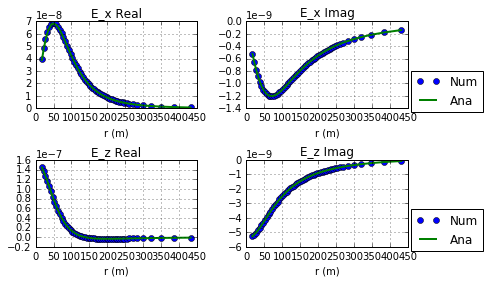

In [2]:
# Plot E
import matplotlib.pyplot as plt

plt.subplot(221)
plt.plot(r, ex_numTest.real,'o',r,exa.real,linewidth=2)
plt.grid(which='both')
plt.title('E_x Real')
plt.xlabel('r (m)')

plt.subplot(222)
plt.plot(r,ex_numTest.imag,'o',r,exa.imag,linewidth=2)
plt.grid(which='both')
plt.title('E_x Imag')
plt.legend(['Num','Ana'],bbox_to_anchor=(1.5,0.5))
plt.xlabel('r (m)')

plt.subplot(223)
plt.plot(r, ez_numTest.real,'o',r,eza.real,linewidth=2)
plt.grid(which='both')
plt.title('E_z Real')
plt.xlabel('r (m)')

plt.subplot(224)
plt.plot(r,ez_numTest.imag,'o',r,eza.imag,linewidth=2)
plt.grid(which='both')
plt.title('E_z Imag')
plt.legend(['Num','Ana'],bbox_to_anchor=(1.5,0.5))
plt.xlabel('r (m)')

plt.tight_layout()
# # plt.show()

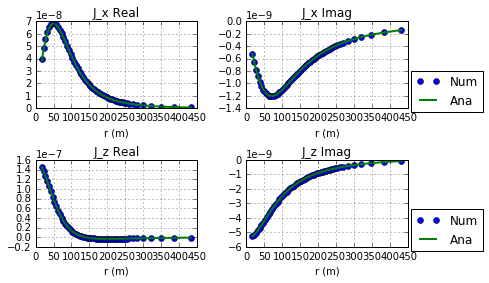

In [3]:
# Plot J 
plt.subplot(221)
plt.plot(r, jx_num.real,'o',r,jxa.real,linewidth=2)
plt.grid(which='both')
plt.title('J_x Real')
plt.xlabel('r (m)')

plt.subplot(222)
plt.plot(r,jx_num.imag,'o',r,jxa.imag,linewidth=2)
plt.grid(which='both')
plt.title('J_x Imag')
plt.legend(['Num','Ana'],bbox_to_anchor=(1.5,0.5))
plt.xlabel('r (m)')

plt.subplot(223)
plt.plot(r, jz_num.real,'o',r,jza.real,linewidth=2)
plt.grid(which='both')
plt.title('J_z Real')
plt.xlabel('r (m)')

plt.subplot(224)
plt.plot(r,jz_num.imag,'o',r,jza.imag,linewidth=2)
plt.grid(which='both')
plt.title('J_z Imag')
plt.legend(['Num','Ana'],bbox_to_anchor=(1.5,0.5))
plt.xlabel('r (m)')

plt.tight_layout()

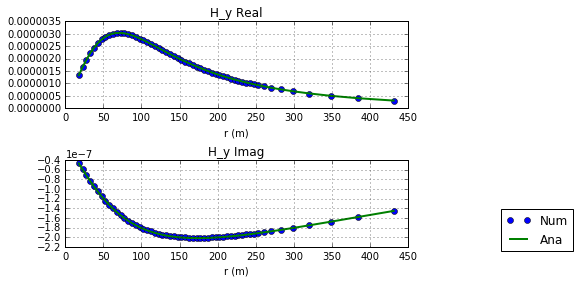

In [4]:
# Plot H
plt.subplot(211)
plt.plot(r,htheta_num.real,'o',r,hya.real,linewidth=2)
plt.grid(which='both')
plt.title('H_y Real')
plt.xlabel('r (m)')

plt.subplot(212)
plt.plot(r,htheta_num.imag,'o',r,hya.imag,linewidth=2)
plt.grid(which='both')
plt.title('H_y Imag')
plt.legend(['Num','Ana'],bbox_to_anchor=(1.5,0.5))
plt.xlabel('r (m)')

plt.tight_layout()




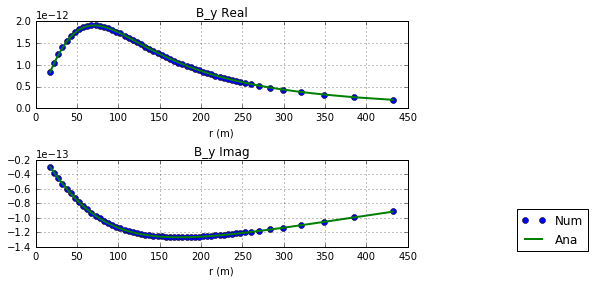

In [8]:
# Plot B
plt.subplot(211)
plt.plot(r,btheta_numTest.real,'o',r,bya.real,linewidth=2)
plt.grid(which='both')
plt.title('B_y Real')
plt.xlabel('r (m)')

plt.subplot(212)
plt.plot(r,btheta_numTest.imag,'o',r,bya.imag,linewidth=2)
plt.grid(which='both')
plt.title('B_y Imag')
plt.legend(['Num','Ana'],bbox_to_anchor=(1.5,0.5))
plt.xlabel('r (m)')

plt.tight_layout()

In [9]:
# print np.mean(htheta_num.real/hya.real)

# print np.mean(htheta_num.imag/hya.imag)

In [6]:
print numFields_ElecDipole.aliasFields

{'b': ['hSolution', 'CCV', '_b'], 'hSecondary': ['hSolution', 'E', '_hSecondary'], 'jPrimary': ['hSolution', 'F', '_jPrimary'], 'h': ['hSolution', 'E', '_h'], 'hPrimary': ['hSolution', 'E', '_hPrimary'], 'j': ['hSolution', 'F', '_j'], 'jSecondary': ['hSolution', 'F', '_jSecondary'], 'e': ['hSolution', 'CCV', '_e']}


In [13]:
mesh.getInterpolationMat?

In [28]:
EM.FDEM.Problem3D_h?